In [23]:
!git clone https://github.com/Daveedlee/yelp_NLP.git

Cloning into 'yelp_NLP'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [8]:
import pandas as pd
import requests
import json
import numpy as np
import re
import string
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lemmatizer import Lemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, GlobalMaxPool1D, Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import optimizers

In [11]:
data_review = [json.loads(line) for line in open('datasets/review.json', 'r')]
data_business = [json.loads(line) for line in open('datasets/business.json', 'r')]
data_user = [json.loads(line) for line in open('datasets/user.json', 'r')]

review_df = pd.DataFrame(data_review)
biz_df = pd.DataFrame(data_business)
user_df = pd.DataFrame(data_user)

r_u_df = review_df.merge(user_df,on = "user_id")
r_u_b_df = r_u_df.merge(biz_df, on = "business_id")
r_u_b_df.columns

Index(['business_id', 'cool_x', 'date', 'funny_x', 'review_id', 'stars_x',
       'text', 'useful_x', 'user_id', 'average_stars', 'compliment_cool',
       'compliment_cute', 'compliment_funny', 'compliment_hot',
       'compliment_list', 'compliment_more', 'compliment_note',
       'compliment_photos', 'compliment_plain', 'compliment_profile',
       'compliment_writer', 'cool_y', 'elite', 'fans', 'friends', 'funny_y',
       'name_x', 'review_count_x', 'useful_y', 'yelping_since', 'address',
       'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude',
       'longitude', 'name_y', 'postal_code', 'review_count_y', 'stars_y',
       'state'],
      dtype='object')

In [12]:
review_text = overall_cleaner(r_u_b_df, ['text', 'user_id', 'state','stars_x'])
review_text.set_index('user_id', inplace=True)

states_l = []

for i in np.unique(r_u_b_df['state']):
    states_l.append(i)
    
nv_df = review_text.groupby('state').get_group('NV')
nv_df.drop('state', axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
interest_st = review_text.groupby('state').count().sort_values('text',ascending=False).index
interest_st = interest_st[0:10]

In [14]:
data_dict = {}

for i in interest_st:
    data_dict[i] = review_text[review_text['state'] == i]

In [6]:
# Apply a first round of text cleaning techniques

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

df.text = nv_df.text.apply(lambda x: clean_text_round1(x))
data_clean = df

ValueError: cannot reindex from a duplicate axis

In [ ]:
nlp = English() 
nlp.max_length = 3000000
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
nv_f1000 = data_clean[0:1000000]

In [ ]:
nv_f1000['nlp'] = nv_f1000.text.apply(lambda x: nlp(x))

In [ ]:
nv_f1000

In [11]:
nv_1000_text = []

for i in nv_f1000.nlp:
    nv_1000_text.append(i)

In [12]:
text_lemma_test = []

for i in nv_1000_text:
    for j in i:
        text_lemma_test.append(j.lemma_)

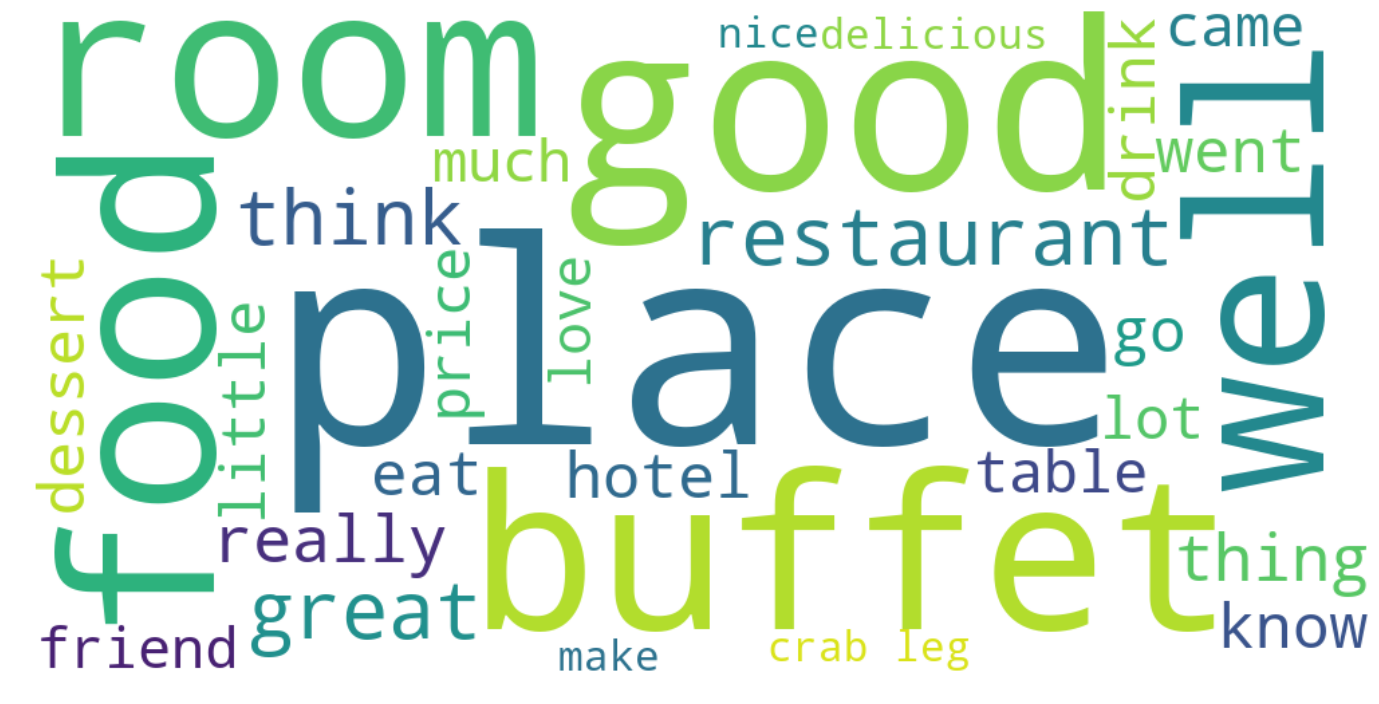

In [13]:
stopwords = set(STOPWORDS)
stopwords.update(['PRON', 'still', 'even', 'one', 'got', 'said', 'say', 'though', 'ye'])

wordcloud = WordCloud(stopwords=stopwords, background_color='White', width=1000, height=500, max_words = 30).generate(' '.join(text_lemma_test))

plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [179]:
embedding_dict={}
with open('datasets/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=100
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(text_lemma_test)
sequences=tokenizer_obj.texts_to_sequences(text_lemma_test)

pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [61]:
train=pad[:nv_df.shape[0]]
test=pad[nv_df.shape[0]:]

In [62]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 68413


In [63]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

In [83]:
model=Sequential()

# embedding_size = 128
# model.add(Embedding(30000, embedding_size))
# model.add(LSTM(25, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(41, activation='softmax'))

# embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
#                    input_length=MAX_LEN,trainable=False)
# 
# model.add(embedding)
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(5, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(6, activation='softmax'))

# model.compile(loss='categorical_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

optimzer = optimizers.SGD(lr=0.02)

model.compile(loss='sparse_categorical_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 128)         3840000   
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 25)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 41)              

In [75]:
X_train,X_test,y_train,y_test=train_test_split(train,
                                               nv_df['stars_x'],
                                               test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (25500, 100)
Shape of Validation  (4500, 100)


In [85]:
history=model.fit(X_train,y_train,
                  batch_size=100,epochs=15,
                  validation_data=(X_test,y_test))

Train on 25500 samples, validate on 4500 samples
Epoch 1/15
25500/25500 [==============================] - 73s 3ms/step - loss: 1.5490 - accuracy: 0.3307 - val_loss: 1.4904 - val_accuracy: 0.3456
Epoch 2/15
25500/25500 [==============================] - 70s 3ms/step - loss: 1.5302 - accuracy: 0.3277 - val_loss: 1.4923 - val_accuracy: 0.3456
Epoch 3/15
25500/25500 [==============================] - 69s 3ms/step - loss: 1.5224 - accuracy: 0.3281 - val_loss: 1.4887 - val_accuracy: 0.3456
Epoch 4/15
 8300/25500 [========>.....................] - ETA: 45s - loss: 1.5172 - accuracy: 0.3290

KeyboardInterrupt: 

In [15]:
from nltk import word_tokenize
from gensim.models import word2vec

In [16]:
df_nv = pd.DataFrame(data_dict['NV']).sample(n=500000)

In [17]:
df_nv.shape

(500000, 3)

In [19]:
target = df_nv['stars_x']
data = df_nv['text'].map(word_tokenize).values

In [20]:
X_train,X_test,y_train,y_test=train_test_split(data, target, test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (425000,)
Shape of Validation  (75000,)


In [18]:
total_vocabulary_train = set(word for text in X_train for word in text)

In [28]:
len(total_vocabulary_train)

321809

In [180]:
glove = {}
with open('datasets/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary_train:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [181]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Logistic Regression', LogisticRegression())])
nb = Pipeline([('W2V Vec', W2vVectorizer(glove)), ('NB Bernoulli', BernoulliNB())])

In [189]:
models = [#('Random Forest', rf),
#           ('Logistic Regression', lr),
         ('NB Bernoulli', nb)]

In [190]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

In [191]:
scores

[('NB Bernoulli', 0.4695720076780526)]

In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [103]:
def sequentialize(word_list):
    """
    takes a word list and creates padded version
    """
    tokenizer.fit_on_texts(word_list)
    tokenized = tokenizer.texts_to_sequences(word_list)
    return sequence.pad_sequences(tokenized, maxlen=100)

In [85]:
tokenizer = text.Tokenizer(num_words=300000)
tokenizer.fit_on_texts(X_train)
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

In [104]:
X_train_padded = sequentialize(X_train)
X_test_padded = sequentialize(X_test)

In [97]:
y_train_d = pd.get_dummies(y_train).values
y_test_d = pd.get_dummies(y_test).values

In [71]:
model = Sequential()

embedding_size = 128
model.add(Embedding(321809, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         41191552  
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 25)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)               

In [119]:
model.fit(X_train_padded, y_train_d, epochs=15, batch_size=1000, validation_split=0.2)

Train on 340000 samples, validate on 85000 samples
Epoch 1/15
340000/340000 [==============================] - 41s 122us/step - loss: 0.3766 - accuracy: 0.8549 - val_loss: 1.4462 - val_accuracy: 0.6528
Epoch 2/15
340000/340000 [==============================] - 41s 122us/step - loss: 0.3657 - accuracy: 0.8588 - val_loss: 1.6484 - val_accuracy: 0.6472
Epoch 3/15
340000/340000 [==============================] - 41s 121us/step - loss: 0.3576 - accuracy: 0.8616 - val_loss: 1.6600 - val_accuracy: 0.6335
Epoch 4/15
340000/340000 [==============================] - 41s 122us/step - loss: 0.3445 - accuracy: 0.8677 - val_loss: 1.8220 - val_accuracy: 0.6459
Epoch 5/15
340000/340000 [==============================] - 41s 121us/step - loss: 0.3422 - accuracy: 0.8684 - val_loss: 1.7465 - val_accuracy: 0.6305
Epoch 6/15
340000/340000 [==============================] - 42s 123us/step - loss: 0.3391 - accuracy: 0.8700 - val_loss: 1.3272 - val_accuracy: 0.6038
Epoch 7/15
340000/340000 [=================

In [203]:
_, accuracy = model.evaluate(X_test_padded, y_test_d)
print('Accuracy: %.2f' % (accuracy*100))

75000/75000 [==============================] - 42s 562us/step
Accuracy: 53.12


In [199]:
test = """My girlfriend and I went to Taco Del Toro in Lincoln Park the other day and we were very upset about how our trip panned out. 
One, Lincoln Park is not our favorite neighborhood. It is way to stuffy and the people are all rich and white. Two, as common 
Logan Square millineal vegetarians, we expected that Taco Del Toro would have vegetarian options, but they DID NOT! This is so 
upsetting in the current year! Taco Del Toro needs to expand its menu for all types of customers and not just rich, 
white Lincoln Park people who do not care about the ANIMALS. Will not be back! But overall it was a fine dining experience"""

seq_test = sequentialize(test)
ynew = model.predict(seq_test)

In [212]:
np.argmax(ynew[0])

4

In [205]:
max(ynew[0])

0.71320385

In [170]:
(3.5-3.7)/5

-0.040000000000000036

In [213]:
def baseline_model():
    model = Sequential()

    embedding_size = 128
    model.add(Embedding(321809, embedding_size))
    model.add(LSTM(25, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [217]:
pip install keras wrapper 

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for wrapper: filename=Wrapper-1.1.0b1-py3-none-any.whl size=7289 sha256=c45bd630e931bd53106e1f2073d01b0c8ba15ef93a57cae728eca3d4dc3995cd
  Stored in directory: /home/jupyter/.cache/pip/wheels/6a/2f/ee/1aa1e6144b846792574a0145c0e023bd9c69968f7cd10f59a3
Successfully built wrapper
Note: you may need to restart the kernel to use updated packages.


In [225]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=3, batch_size=128)

In [221]:
from sklearn.model_selection import KFold

In [222]:
Kfold = KFold(n_splits=3, shuffle=True)

In [ ]:
results = cross_val_score(estimator, X_train_padded, y_train_d, cv=Kfold)

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
382500/382500 [==============================] - 335s 877us/step - loss: 0.9140 - accuracy: 0.6274
Epoch 2/3
382500/382500 [==============================] - 332s 868us/step - loss: 0.7752 - accuracy: 0.6812
Epoch 3/3
357248/382500 [===========================>..] - ETA: 21s - loss: 0.7179 - accuracy: 0.7049